In [ ]:
!pip install ktrain

In [2]:
!pip install yahoo-fin

In [ ]:
!pip install requests_html

In [4]:
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import yahoo_fin.stock_info as si
from yahoo_fin import options

/usr/local/lib/python3.6/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [7]:
import tensorflow as tf
import ktrain
from ktrain import text

In [10]:
data_train = pd.read_excel('/content/train.xlsx', dtype=str)
data_train.head()

,Reviews,Sentiment
0,"When I first tuned in on this morning news, I ...",neg
1,"Mere thoughts of ""Going Overboard"" (aka ""Babes...",neg
2,Why does this movie fall WELL below standards?...,neg
3,Wow and I thought that any Steven Segal movie ...,neg
4,"The story is seen before, but that does'n matt...",neg


In [11]:
data_test = pd.read_excel('/content/test.xlsx', dtype=str)
data_test.head()

,Reviews,Sentiment
0,Who would have thought that a movie about a ma...,pos
1,After realizing what is going on around us ......,pos
2,I grew up watching the original Disney Cindere...,neg
3,David Mamet wrote the screenplay and made his ...,pos
4,"Admittedly, I didn't have high expectations of...",neg


In [12]:
(X_train, y_train), (X_test, y_test), preprocess = text.texts_from_df(train_df=data_train, 
                   text_column='Reviews', label_columns='Sentiment', 
                   val_df=data_test, 
                   maxlen=400, 
                   preprocess_mode='bert')

downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


In [13]:
X_train[0].shape

(25000, 400)

In [14]:
model = text.text_classifier(name='bert', train_data=(X_train, y_train), 
                             preproc=preprocess)

Is Multi-Label? False
maxlen is 400
done.


In [15]:
learner = ktrain.get_learner(model=model, 
                             train_data=(X_train, y_train), 
                             val_data=(X_test, y_test), 
                             batch_size=6)

In [ ]:
learner.fit_onecycle(lr=2e-5, epochs=1)

In [17]:
learner

In [18]:
predictor = ktrain.get_predictor(model=learner.model, preproc=preprocess)

In [20]:
testing_data = [ 'This movie was horrible! The plot was boring. Acting was okay, though.',
                'The film really sucked. I want my money back.',
                'The plot had too many holes.',
                'What a beautiful romantic comedy. 10/10 would see again!',
                ]

In [21]:
predictor.predict(texts=testing_data)

['neg', 'neg', 'neg', 'pos']

In [22]:
predictor.predict(texts=testing_data, return_proba=True)

array([[0.997152  , 0.00284804],
       [0.99406946, 0.00593052],
       [0.9803694 , 0.01963067],
       [0.00292435, 0.9970757 ]], dtype=float32)

In [23]:
website_url = 'https://finviz.com/quote.ashx?t='
company_tikcers = ['AMD', 'AMZN', 'FB', 'GOOG']

In [25]:
news_tables = {}

for ticker in company_tikcers:
  url = website_url + ticker

  req = Request(url=url, headers={'user-agent': 'my-scrape'})
  response = urlopen(req)
  html = BeautifulSoup(response, 'html')
  news_data = html.find(id='news-table')
  news_tables[ticker] = news_data

In [26]:
parsed_data = []

for ticker, news_table in news_tables.items():
  for row in news_table.findAll('tr'):
    title = row.a.text
    date_data = row.td.text.split(' ')

    if len(date_data) == 1:
      time = date_data[0][0:7]
    else:
      date = datetime.datetime.strptime(date_data[0], '%b-%d-%y').strftime('%Y/%m/%d')
      time = date_data[1][0:7]

    parsed_data.append([ticker, date, time, title])

In [27]:
dataset = pd.DataFrame(parsed_data, columns=["Company", "Date", "Time", "News Headline"])
dataset.to_csv('CompanyNewsHeadlines_WithoutSentiment.csv', index=False)
dataset.head()

,Company,Date,Time,News Headline
0,AMD,2020/11/13,08:00PM,Mergers Have Bounced Back. But Will Biden See ...
1,AMD,2020/11/13,08:30AM,AMD Is Shattering Intel's Dominance in Style
2,AMD,2020/11/13,07:25AM,"Cramer Gives His Opinion On Blackstone, Advanc..."
3,AMD,2020/11/12,12:30PM,"Forget AMD, This Hot Gaming Stock Has Almost D..."
4,AMD,2020/11/12,09:10AM,IBM Teams Up With AMD to Enhance AI and Securi...


In [28]:
dataset['Sentiment'] = dataset['News Headline'].apply(lambda headline: predictor.predict(texts=headline))

In [29]:
dataset.head()

,Company,Date,Time,News Headline,Sentiment
0,AMD,2020/11/13,08:00PM,Mergers Have Bounced Back. But Will Biden See ...,neg
1,AMD,2020/11/13,08:30AM,AMD Is Shattering Intel's Dominance in Style,pos
2,AMD,2020/11/13,07:25AM,"Cramer Gives His Opinion On Blackstone, Advanc...",pos
3,AMD,2020/11/12,12:30PM,"Forget AMD, This Hot Gaming Stock Has Almost D...",pos
4,AMD,2020/11/12,09:10AM,IBM Teams Up With AMD to Enhance AI and Securi...,pos


In [30]:
dataset['Date'] = pd.to_datetime(dataset.Date).dt.date

In [ ]:
dataset.to_csv('CompanyNewsHeadlines.csv', index=False)

In [31]:
max_min_date = dataset.groupby(['Company']).agg({'Date': [np.min,np.max]})
max_min_date

Date            
               amin        amax
Company                        
AMD      2020-10-27  2020-11-13
AMZN     2020-11-10  2020-11-14
FB       2020-11-05  2020-11-14
GOOG     2020-11-09  2020-11-14

In [32]:
dataset['MaxDate'] = dataset.groupby('Company').Date.transform('max')
dataset['MinDate'] = dataset.groupby('Company').Date.transform('min')

dataset.head()

,Company,Date,Time,News Headline,Sentiment,MaxDate,MinDate
0,AMD,2020-11-13,08:00PM,Mergers Have Bounced Back. But Will Biden See ...,neg,2020-11-13,2020-10-27
1,AMD,2020-11-13,08:30AM,AMD Is Shattering Intel's Dominance in Style,pos,2020-11-13,2020-10-27
2,AMD,2020-11-13,07:25AM,"Cramer Gives His Opinion On Blackstone, Advanc...",pos,2020-11-13,2020-10-27
3,AMD,2020-11-12,12:30PM,"Forget AMD, This Hot Gaming Stock Has Almost D...",pos,2020-11-13,2020-10-27
4,AMD,2020-11-12,09:10AM,IBM Teams Up With AMD to Enhance AI and Securi...,pos,2020-11-13,2020-10-27


In [49]:
company_early_late_dates = {}

for index, row in dataset.iterrows():
  if row['Company'] in company_early_late_dates:
      company_early_late_dates[row['Company']]['early'] = row['MinDate']
      company_early_late_dates[row['Company']]['late'] = row['MaxDate']
  else:
    company_early_late_dates[row['Company']] = {'early': None, 'late': None}

company_early_late_dates

{'AMD': {'early': datetime.date(2020, 10, 27),
  'late': datetime.date(2020, 11, 13)},
 'AMZN': {'early': datetime.date(2020, 11, 10),
  'late': datetime.date(2020, 11, 14)},
 'FB': {'early': datetime.date(2020, 11, 5),
  'late': datetime.date(2020, 11, 14)},
 'GOOG': {'early': datetime.date(2020, 11, 9),
  'late': datetime.date(2020, 11, 14)}}

In [50]:
for key, value in company_early_late_dates.items():
  print(key, '->', value)
  tmp_df = si.get_data(key, start_date=value['early'], end_date=value['late'])
  tmp_df['date'] = tmp_df.index
  tmp_df.to_csv(key + '_BERT.csv', index=False)

AMD -> {'early': datetime.date(2020, 10, 27), 'late': datetime.date(2020, 11, 13)}
AMZN -> {'early': datetime.date(2020, 11, 10), 'late': datetime.date(2020, 11, 14)}
FB -> {'early': datetime.date(2020, 11, 5), 'late': datetime.date(2020, 11, 14)}
GOOG -> {'early': datetime.date(2020, 11, 9), 'late': datetime.date(2020, 11, 14)}


In [51]:
sentiment_result = {}
for value in dataset['Sentiment']:
  if value in sentiment_result:
    if value == 'neu':
      sentiment_result['neu'] += 1
    elif value == 'pos':
      sentiment_result['pos'] += 1
    elif value == 'neg':
      sentiment_result['neg'] += 1
  else:
    sentiment_result[value] = 1

sentiment_result

{'neg': 198, 'pos': 202}

In [52]:
result_by_companies = {}
for index, row in dataset.iterrows():
  if row['Company'] in result_by_companies:
    if row['Sentiment'] == 'neu':
      result_by_companies[row['Company']]['neu'] +=1
    if row['Sentiment'] == 'pos':
      result_by_companies[row['Company']]['pos'] +=1
    if row['Sentiment'] == 'neg':
      result_by_companies[row['Company']]['neg'] +=1
  else:
    result_by_companies[row['Company']] = {'neg': 0, 'neu': 0, 'pos': 0}

result_by_companies

{'AMD': {'neg': 42, 'neu': 0, 'pos': 57},
 'AMZN': {'neg': 48, 'neu': 0, 'pos': 51},
 'FB': {'neg': 54, 'neu': 0, 'pos': 45},
 'GOOG': {'neg': 52, 'neu': 0, 'pos': 47}}

In [53]:
dataframe_list = []
for key, value in result_by_companies.items():
  print(key, '->', value)
  dataframe_list.append([key, value['neg'], value['neu'], value['pos']])


dataset_company = pd.DataFrame(dataframe_list, columns=["Company", "Neg", "Neu", "Pos"])
dataset_company.head()

AMD -> {'neg': 42, 'neu': 0, 'pos': 57}
AMZN -> {'neg': 48, 'neu': 0, 'pos': 51}
FB -> {'neg': 54, 'neu': 0, 'pos': 45}
GOOG -> {'neg': 52, 'neu': 0, 'pos': 47}


,Company,Neg,Neu,Pos
0,AMD,42,0,57
1,AMZN,48,0,51
2,FB,54,0,45
3,GOOG,52,0,47


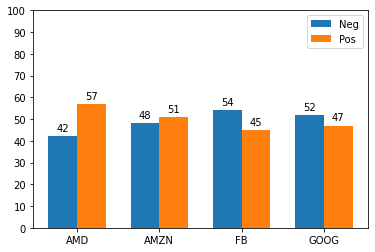

In [54]:
index = np.arange(len(company_tikcers))
score_label = np.arange(0, 110, 10)

bar_width = 0.35

fig, ax = plt.subplots()
barNeg = ax.bar(index - bar_width/2, dataset_company['Neg'], bar_width, label='Neg')
barPos = ax.bar(index + bar_width/2, dataset_company['Pos'], bar_width, label='Pos')

ax.set_xticks(index)
ax.set_xticklabels(company_tikcers)

ax.set_yticks(score_label)
ax.set_yticklabels(score_label)


ax.legend()

def insert_data_labels(bars):
  for bar in bars:
    bar_height = bar.get_height()
    ax.annotate('{0:.0f}'.format(bar.get_height()),
                xy=(bar.get_x() + bar.get_width() / 2, bar_height),
                xytext=(0,3),
                textcoords='offset points',
                ha='center',
                va='bottom'
    )

insert_data_labels(barNeg)
insert_data_labels(barPos)

plt.show()


In [55]:
def percentage(part, whole):
  temp = 100 * float(part) / float(whole)
  return format(temp, '.2f')

In [56]:
def visualization(positive, neutral, negative):
  labels = ['Positive [' + str(positive) + '%]','Neutral [' + str(neutral) + '%]',
            'Negative [' + str(negative) + '%]']
  sizes = [positive, neutral, negative]
  colors = ['lightgreen', 'gold', 'red']
  patches, texts = plt.pie(sizes, colors=colors, startangle=90)
  plt.title('Aggregate sentiment value of the economic news headlines')
  plt.legend(patches, labels, loc="best")
  plt.axis('equal')
  plt.tight_layout()
  plt.show()

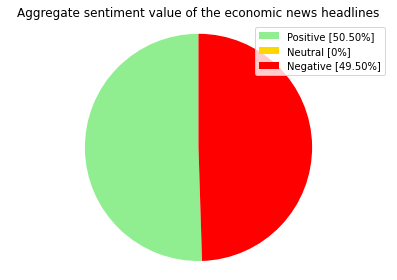

In [58]:
# össze gazdasági megítélés ezen cégek híreire fókuszálva
all_num = sentiment_result['pos'] + sentiment_result['neg']
pos_percent = percentage(part=sentiment_result['pos'], whole=all_num)
neg_percent = percentage(part=sentiment_result['neg'], whole=all_num)

visualization(positive=pos_percent,neutral=0, negative=neg_percent)

In [59]:
amd_stock = pd.read_csv("/content/AMD_BERT.csv")
amzn_stock = pd.read_csv("/content/AMZN_BERT.csv")
fb_stock = pd.read_csv("/content/FB_BERT.csv")
goog_stock = pd.read_csv("/content/GOOG_BERT.csv")

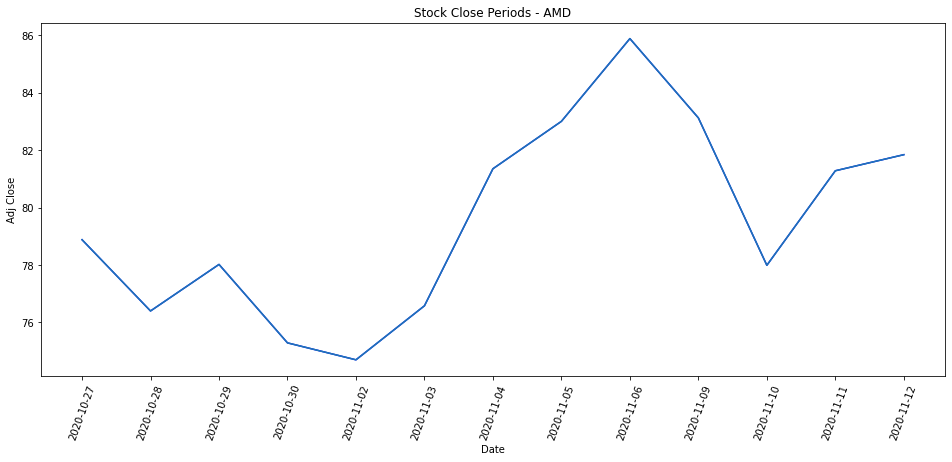

In [43]:
plt.figure(figsize=(16.2, 6.5))
plt.title('Stock Close Periods - AMD')
plt.plot(amd_stock['adjclose'], label='AMD', color = 'blue')
x = amd_stock['date']
y = amd_stock['adjclose']
plt.plot(x, y)
plt.xticks(rotation=70)
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.show()

In [44]:
pd.options.display.float_format = '{:,.3f}'.format
amd_stock.corr()

,open,high,low,close,adjclose,volume
open,1.000,0.953,0.899,0.811,0.811,0.263
high,0.953,1.000,0.962,0.910,0.910,0.133
low,0.899,0.962,1.000,0.971,0.971,-0.054
close,0.811,0.910,0.971,1.000,1.000,-0.089
adjclose,0.811,0.910,0.971,1.000,1.000,-0.089
volume,0.263,0.133,-0.054,-0.089,-0.089,1.000


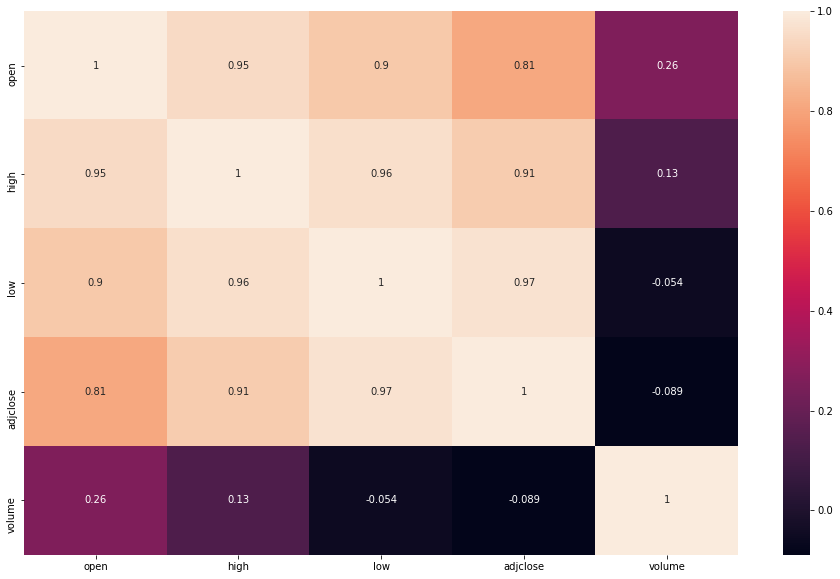

In [45]:
# amd stock correlation analisys

plt.figure(figsize=(16, 10))
sns.heatmap(amd_stock[['open', 'high', 'low', 'adjclose', 'volume']].corr(), annot=True)
plt.show()

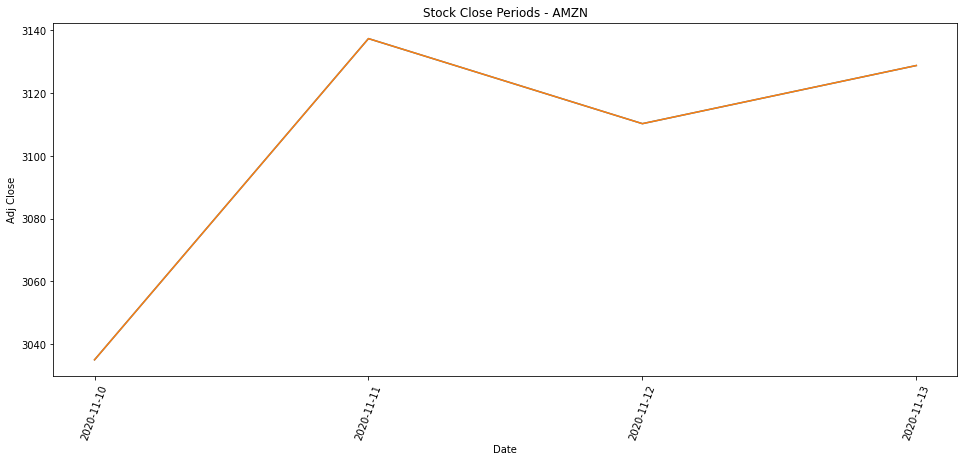

In [46]:
plt.figure(figsize=(16.2, 6.5))
plt.title('Stock Close Periods - AMZN')
plt.plot(amzn_stock['adjclose'])
x = amzn_stock['date']
y = amzn_stock['adjclose']
plt.plot(x, y)
plt.xticks(rotation=70)
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.show()

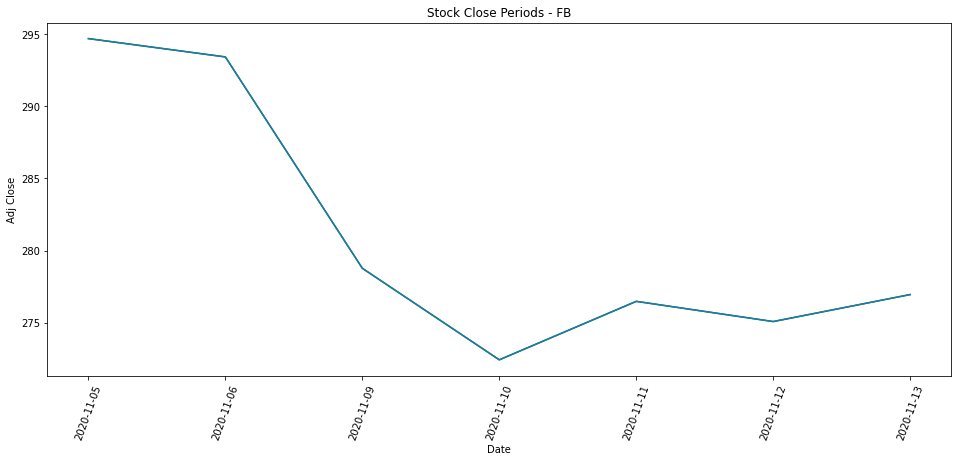

In [47]:
plt.figure(figsize=(16.2, 6.5))
plt.title('Stock Close Periods - FB')
plt.plot(fb_stock['adjclose'], label='FB', color = 'green')
x = fb_stock['date']
y = fb_stock['adjclose']
plt.plot(x, y)
plt.xticks(rotation=70)
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.show()

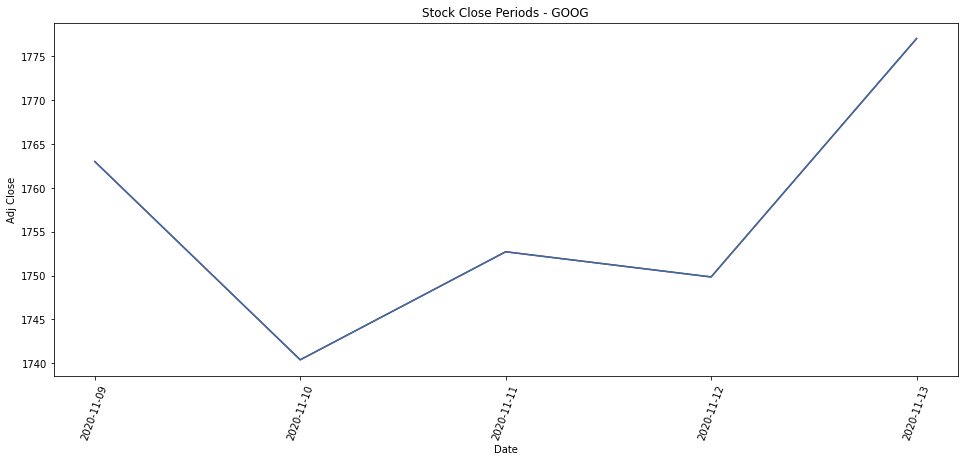

In [48]:
plt.figure(figsize=(16.2, 6.5))
plt.title('Stock Close Periods - GOOG')
plt.plot(goog_stock['adjclose'], label='GOOG', color = 'red')
x = goog_stock['date']
y = goog_stock['adjclose']
plt.plot(x, y)
plt.xticks(rotation=70)
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.show()